# Comprehensive Guide on Feature Selection
[Kaggle: Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection)

# 1. Introduction
3 key Feature selection methods
1. Filter methods
2. Wrapper methods
3. Embedded methods

## Filter Methods
1. Basic methods
2. Univariate methods
3. Information gain
4. Fischer score / ANOVA
5. Correlation Matrix with Heatmap

## Wrapper Methods
1. Forward Seleciton
2. Backward Elimination
3. Exhaustive Feature Selection
4. Recursive Feature Elimination
5. Recursive Feature Elimination with Cross-Validation

## Embedded Methods
1. Lasso
2. Ridge
3. Tree Importance

# 2. Filter Methods
- Preprocessing step
- Selection of feature is ML model agnostic
- Scores vs statistical tests
- Rely on feature characteristics
- Tend to be computationally less expensive
- Quick screen and removal of irrelevant features

## 2.1 Basic methods
- Remove constants
- Remove almost constant features

### 2.1.1 Remove constant features
- Just show the same value
- Easy first step

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! head -1 ./inputs/train.csv

ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136

In [3]:
def get_data():
    df_train = pd.read_csv("./inputs/train.csv", nrows=35000)
    df_test = pd.read_csv("./inputs/test.csv", nrows=15000)
    y_train = df_train["target"]
    X_train = df_train.drop(["ID_code","target"], axis=1)
    X_test = df_test.drop("ID_code", axis=1)
    return X_train, X_test, y_train

In [4]:
X_train, X_test, y_train = get_data()

In [5]:
X_train.shape, X_test.shape

((35000, 200), (15000, 200))

In [6]:
# using sklearn variancethreshold to find constant features

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_train) # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [7]:
# get_support isa boolean vector that indicates which features are retrained
# if we sum over get_suport, we get the number of fatueres that are not constant
sel.get_support().sum()

200

In [8]:
# print the constant features
print(X_train.columns[~sel.get_support()])

Index([], dtype='object')


In [9]:
# we can then drop these columns from the train and test sets
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [10]:
# check the shape of training and test set
X_train.shape, X_test.shape

((35000, 200), (15000, 200))

### 2.1.2 Remove quasi-constant features
- Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. Ingenreal, these features provide littfle if any information that allows a machine learming model to discriminate or predict a terget.
- There can be exceptions, so we should be careful when removing these features
- We use again the Variance Threshold function from sklearn
- `threshold` means that (1 - `threshold`) % of values have the same single value

In [11]:
X_train, X_test, y_train = get_data()
X_train.shape, X_test.shape

((35000, 200), (15000, 200))

In [12]:
sel = VarianceThreshold(threshold=0.01) # 0.01 indicates 99% of observations approximately

sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [13]:
# number of non quasi-constant features
sel.get_support().sum()

199

In [14]:
# print the quasi-constant features
print(X_train.columns[~sel.get_support()])

Index(['var_68'], dtype='object')


In [15]:
sel_5 = VarianceThreshold(threshold=0.05) # Let's get 95% observations
sel_5.fit(X_train)
sel_5.get_support().sum()

193

In [16]:
# print the quasi-constant features
print(X_train.columns[~sel_5.get_support()])

Index(['var_12', 'var_68', 'var_91', 'var_103', 'var_108', 'var_148',
       'var_161'],
      dtype='object')


In [17]:
# We can then remove the features from training and test set

X_train_fs = sel_5.transform(X_train)
X_test_fs = sel_5.transform(X_test)

X_train_fs.shape, X_test_fs.shape 

((35000, 193), (15000, 193))

## 2.2 Univariate selection methods
- Select best methods based on univariate statistical tests like ANOVA
- Also a Pre-processing step
- Methods from sklearn assume Gaussian distribution
- 4 scikit learn methods
 - SelectKBest
 - SelectPercentile
 - SelectFpr, SelectFdr, SelectFwe
 - GenericUnivariateSelection
 
- We will discuss only the first 2 (most commonly used)

### 2.2.1 SelectKBest
- This method select features according to the k highest scores
- For instance, we can perfom a chi-square test to the samples to retrieve only the two best features from iris dataset as follows
- iris is used as chi-squared test only uses categorical variables

In [18]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2

X,y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [19]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [20]:
# select the two best features
X_new = SelectKBest(chi2, k=2).fit_transform(X,y)
X_new.shape

(150, 2)

### 2.2.2 SelectPercentile
- Select features according to a percentile of the highest scores


In [21]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

X, y = load_digits(return_X_y=True)

X.shape

(1797, 64)

In [22]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [23]:
# now select features based on top 10 percentile

X_new = SelectPercentile(chi2, percentile=10).fit_transform(X,y)
X_new.shape

(1797, 7)

- We can see that only 7 features lie on the top 10 percentile and hence we select them accordingly

### Important information
- These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile)
- For regression tasks: f_regression, mutual_info_regression
- For classification tasks: chi2, f_classif, mutual_info_classif

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation

### Feature selection with sparse data
- If you use sparse data (i.e. data represented as sparse matrices), chi2, mutual_info_regression, mutual_info_classif will deal the data without making it dense

### Warning
- Beware not to use a regression scoring function with a classification problem, you will get useless resutls

## 2.3 Information Gain
- Information gain or mutual information measures how much information the rpesence/absense of a feature contrubutes to making the correc tprediction on the target


### 2.3.1 mutual_info_classif
- It estimates mutual information for a discrete target variable
- Mutual Information (MI) between 2 random variables is a non-negative value which measure the dependency between the variables.
- It is equal to zero if an only with 2 random variables are independent
- Higher values mean higher dependency
- Rely on nonparametric methodas based on entropy estimation from k-NN distances (and therefore require more data to yield better results)
- It can be used for univariate feture selection

### 2.3.2 mutual_info_regression
- Estimate MI for continouus target variable

## 2.4 Fisher Score (Chi-square implementation)
- It is the chi-square implementation in sklearn
- Computes chi-squared stats between each non-negative feature and class
- This score should be used to evaluate categorical variables in a classification task
- It compares the observed distribution of the different classes of target T among the different categories of the feature, against the expected distribution of the target classes, regardless of the feature categories

In [24]:
# load libraries
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2

In [25]:
# LOad Data
# load iris data
iris = load_iris()

In [26]:
# create featuers and target
X = iris.data
y = iris.target

#convert to categorical data by converting data to integers
X = X.astype(int)

In [27]:
# Compare Chi-Squared Statistics
# select 2 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=2)
X_kbest = chi2_selector.fit_transform(X,y)

In [28]:
# view results
print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {X_kbest.shape[1]}")

Original number of features: 4
Reduced number of features: 2


## 2.5 ANOVA F-value for Feature Selection

- If the features are categorical, we calculate chi-square statistics between feature and target vector
- If features are numerical, we will compute ANOVA F-value between each feature and the target vector

In [30]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [31]:
iris = load_iris()
X = iris.data
y = iris.target

In [32]:
# Select features with Best ANOVA F-values

fvalue_selector = SelectKBest(f_classif, k=2)

X_kbest = fvalue_selector.fit_transform(X,y)

In [33]:
# view results
print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {X_kbest.shape[1]}")

Original number of features: 4
Reduced number of features: 2


## 2.6 Correlation-Matrix with Heatmap
- **Correlation** is a measure of the linear relationship of 2 or more variables
- Good variables are highly correlated with the target
- Correlated predictor variable sprovide redundant information
- Variables should be correlated with the target but uncorrelated among themselves
- Correlation Feature Selection evaluate subsets of feature on the basis of the hypothesis above

- Pearson correlation: returned coefficients vary between -1 and 1, with zero meaning no correlation


In [34]:
iris = load_iris()
X = iris.data
y = iris.target

In [35]:
df = pd.DataFrame(X)

In [36]:
df

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [37]:
corr_matrix = df.corr()
print(corr_matrix)

          0         1         2         3
0  1.000000 -0.117570  0.871754  0.817941
1 -0.117570  1.000000 -0.428440 -0.366126
2  0.871754 -0.428440  1.000000  0.962865
3  0.817941 -0.366126  0.962865  1.000000


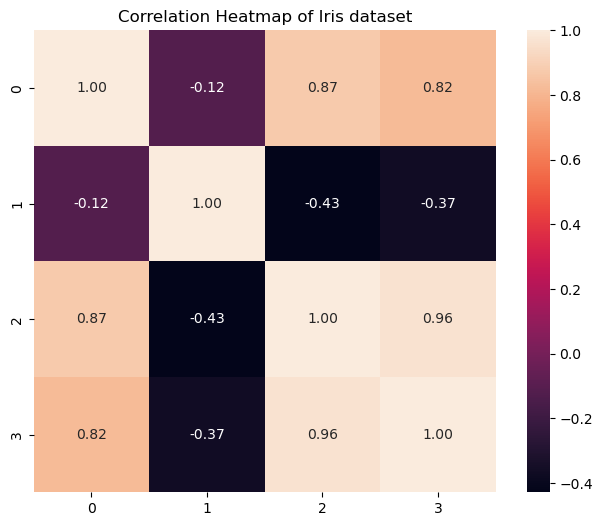

In [39]:
plt.figure(figsize=(8,6))
plt.title("Correlation Heatmap of Iris dataset")
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", linecolor="black")
plt.show()

In [42]:
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper

,0,1,2,3
0,NaN,-0.11757,0.871754,0.817941
1,NaN,NaN,-0.428440,-0.366126
2,NaN,NaN,NaN,0.962865
3,NaN,NaN,NaN,NaN


In [43]:
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

[3]


In [44]:
# Drop Marked Features
df1 = df.drop(df.columns[to_drop], axis=1)

In [45]:
df1

,0,1,2
0,5.1,3.5,1.4
1,4.9,3.0,1.4
2,4.7,3.2,1.3
3,4.6,3.1,1.5
4,5.0,3.6,1.4
...,...,...,...
145,6.7,3.0,5.2
146,6.3,2.5,5.0
147,6.5,3.0,5.2
148,6.2,3.4,5.4


# 3. Wrapped methods
- Follows a 3 step framework:
  - Select a subset of features
  - Train a model on this subset of features
  - Add or remove features based on model results (inferences)


- It tends to be computationally very expensive


- Examples include
  - 1. Forward selection
  - 2. Backward elimination
  - 3. Exhaustive feature selection
  - 4. Recursive feature elimination
  - 5. Recursive feature elimination with cross-validation
 

## 3.1 Forward selection
- Start with zero features
- Each iteration adds the feature that best improves our model
- It stops when the addition of a new variable does not improve performance of the model

- To evaluate the best feature it uses a evaluation metric / criteria such as roc_auc ofr classification and R squared for regression

- This is a **greedy** selection procedure, as it evaluates all possible combinations of feature in each iteration
- Feature space can become unfeasible depending on the size of the problem

In [47]:
# step forward feature selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [48]:
# load dataset
data = pd.read_csv("../house_prices_advanced_regression/inputs/train.csv")
data.shape

(1460, 81)

In [50]:
# In practice, feature selection should be done after data pre-processing
# So ideally, all the categorical variables are encoded into numbers
# and then you can assess how deterministic they are of the target
# here for simplicity I will use only numerical variables

# select numerical columns:
numerics = ["int16","int32","int64","float16","float32","float64"]
numeric_vars = list(data.select_dtypes(include=numerics).columns)
data1 = data[numeric_vars]
data.shape

(1460, 81)

In [52]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data1.drop(labels=["Id","SalePrice"], axis=1),
    data1["SalePrice"],
    test_size=0.3,
    random_state=0
)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [56]:
# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set() #set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for column_index in range(len(corr_matrix.columns)):
        for row_index in range(column_index):
            if abs(corr_matrix.iloc[row_index, column_index]) > threshold:
                colname = corr_matrix.columns[column_index]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features', corr_features)

correlated features {'GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea'}


In [58]:
# removed correlated features
X_train = X_train.drop(labels=corr_features, axis=1)
X_test = X_test.drop(labels=corr_features, axis=1)

In [59]:
X_train.shape, X_test.shape

((1022, 33), (438, 33))

In [60]:
X_train.fillna(0, inplace=True)

In [63]:
# step forward feature selection

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(RandomForestRegressor(),
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=3,
           n_jobs=3)

sfs_forward_fitted = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  33 out of  33 | elapsed:    7.8s finished

[2023-03-22 11:09:07] Features: 1/10 -- score: 0.6677356911525713[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:    5.6s finished

[2023-03-22 11:09:13] Features: 2/10 -- score: 0.7228543478833437[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  31 out of  31 | elapsed:    6.1s finished

[2023-03-22 11:09:19] Features: 3/10 -- score: 0.745200184211091[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    6.3s finished

[2023-03-22 11:09:25] Features: 4/10 -- score: 0.7639842109190275[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  29 out of  29 | elapsed:    6.7s finished

[2023-03-22

In [64]:
sfs_forward_fitted.k_feature_idx_

(3, 4, 5, 8, 13, 15, 16, 18, 21, 23)

In [65]:
X_train.columns[list(sfs_forward_fitted.k_feature_idx_)]

Index(['OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'GarageCars'],
      dtype='object')

- We can see that forward feature selection results in the above columns being selected from all the given columns

## 3.2 Backward Elimination

- We start with all features
- We remove the least significant feature at each iteration, which improves the performance of the model
- Repeat this until no improvement is observed on removal of features

In [66]:
# Step backward feature elimination

sfs2 = SFS(RandomForestRegressor(),
           k_features=10,
           forward=False,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=3,
           n_jobs=3)

sfs_backward_fitted = sfs2.fit(np.array(X_train), y_train) 

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  33 out of  33 | elapsed:   32.9s finished

[2023-03-22 11:18:27] Features: 32/10 -- score: 0.8617481706053997[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:   30.3s finished

[2023-03-22 11:18:57] Features: 31/10 -- score: 0.8609262338843716[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  31 out of  31 | elapsed:   30.5s finished

[2023-03-22 11:19:28] Features: 30/10 -- score: 0.8622116551287564[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   30.0s finished

[2023-03-22 11:19:58] Features: 29/10 -- score: 0.8609048303469239[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  29 out of  29 | elapsed:   34.2s finished

[2023-

In [67]:
sfs_backward_fitted.k_feature_idx_

(0, 3, 6, 8, 13, 15, 21, 23, 24, 25)

In [69]:
X_train.columns[list(sfs_backward_fitted.k_feature_idx_)]

Index(['MSSubClass', 'OverallQual', 'YearRemodAdd', 'BsmtFinSF1', '2ndFlrSF',
       'GrLivArea', 'KitchenAbvGr', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

- Look how first iterations of Backward Selection are ~3 times slower than Forward

## 3.3 Exhaustive Feature Selection

- Best subset of fatures is selected over all possible feature subsets
- Optimized using a performance metric
- Logistic Regression on 4 features -> 15 combinations
  - All combinations of 1 feature (4)
  - All combinations of 2 features (6)
  - All combinations of 3 featues (4)
  - All combinations of 4 feature (1)

- Greedu algorithm that performs all combinations
- Extremely computationally expensive
- mlxtend implementation of exhaustive feature selection contains a stopping criteria with an arbitrarily set number of features
- This may lead to suboptimal results

## 3.4 Recursive Feature eliminiation
- Greedy optimization
- Repeatedly creates models and keeps aside the best or the wors performing feature at each iteration
- It constructs the next model with the left features until all the features are exhausted
- It then ranks the features based on the order of their elimination
- In the rost case, given N number of features, the search will be done on 2N combinations of features

## 3.5 Recursive Feature Elimination with Cross-Validation
- Same thing, but with cross_validation

# 4. Embedded Methods
- Uses model with embedded feature seleciton in their training process in order to extract most relevant features
- Regularization methods are the most commonly used embedded methods, which penalize a feature given a coefficient threshold (Lasso, Ridge)
- Regularization methods also introducte additional constraints into the optimization of a prediction model, which lead the mode toward lower complexity

## 4.1 Lasso Regression

- Performs L1 regularization, wihch adds penalty equivalent to absolute value of the magnitude of coefficients
- May shrink some coefficients to zero

In [70]:
# load libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [71]:
# load dataset
data = pd.read_csv("../house_prices_advanced_regression/inputs/train.csv")
data.shape

(1460, 81)

In [72]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data1.drop(labels=["Id","SalePrice"], axis=1),
    data1["SalePrice"],
    test_size=0.3,
    random_state=0
)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [73]:
# feature sin the house dataset are in very different scales
# It helps the regression to scale them

scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [74]:
sel_ = SelectFromModel(Lasso(alpha=100))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=Lasso(alpha=100))

In [75]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True])

In [78]:
# make a list with the selected features and print the outputs

selected_feat = X_train.columns[sel_.get_support()]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 36
selected features: 33
features with coefficients shrank to zero: 3


- Lasso regularization helps to remove non-important features
- Keep an eye on the monitor if the penalization is not too high

## 4.2 Random Forest Importance
- Most popular machine learning algorithms
- Provide in general a good predictive performance, low overfitting and easy interpretability
- Lots of decision trees built over random extraction of observations from the dataset
- Not every tree sees all the features or all the observations, therefore trees are de-correlated and less prone to over-fitting
- Each tree is a sequence of yes and no answers

- Classification - measure of impurity in Gini or information Gain/Entropy
- Regression = measure of impurity is variance

In [80]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [87]:
df = pd.read_csv("../mushroom-classification/mushrooms.csv")
df.shape

(8124, 23)

In [88]:
X = df.drop(["class"], axis=1)
y = df["class"]

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [90]:
# Encode categorical variables
X = pd.get_dummies(X, prefix_sep="_")
y = LabelEncoder().fit_transform(y)

In [91]:
# Normalize feature vector
X2 = StandardScaler().fit_transform(X)

In [92]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size =0.3, random_state = 0) 

In [97]:
# instantiate the calssifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [98]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [99]:
y_pred = clf.predict(X_test)

### Feature Importance
 - Decision trees models which are based on ensemble (Extra Trees, Random FOrests) can be used to rank the importance of different features

<Axes: >

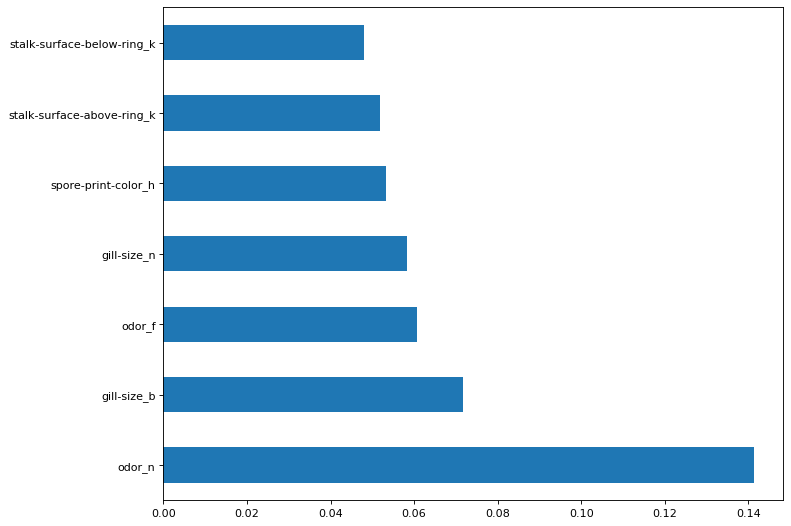

In [100]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns)
feat_importances.nlargest(7).plot(kind='barh')

# How to choose the right feature selection method?

## Numerical Input, Numerical Output

- Regression predictive modeling problem with numerical input variables
- Correlation coefficients
  - **Linear correlation**: pearson's correlation coefficient
  - **Non-linear correlation**: Spearman's / Keandall's coefficient


## Numerical Input, Categorical Output
- Classification predictive modeling problem with numerical input variables
- Most common example of classificaiton problem
- Tests
  - **Linear relation**: ANOVA correlation coefficient
  - **Non-linear relation**: Kendall's rank coefficient (non-linear)
  
## Categorical Input, Numerical Output
- This is a regression predictive modeling problem with cateogircla input variables
- Strange example of a regression problem (e.g., we will no encounter it often)
- We can use the same methods explained above, but in reverse
- Tests
  - **Linear relation**: ANOVA correlation coefficient
  - **Non-linear relation**: Kendall's rank coefficient (non-linear)
  
  
## Categorical Input, Categorical Output
- This is a classification predictive modeling problem with categorical input variables
- Most common correaltion measure for categorical data: chi-squared test
- ALso: mutual information (information gain)

- Tests
  - Chi-Squared test
  - Mutual Information
  
## Mixed data types
- Mutual information (powerful), but require many labels to perform properly

https://www.udemy.com/course/feature-selection-for-machine-learning/